In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

2022-12-30 09:19:57.346425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 09:19:57.544532: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-30 09:19:58.181933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-30 09:19:58.182014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

## Load the new CMAPPS data

In [2]:
mypath = 'N-CMAPSS_DL/N-CMAPSS/Samples_whole/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

train_units = [2,5,10,16,18,20]
test_units = [11,14,15]

test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
train_files = list(set(onlyfiles) - set(test_files))

['Unit5_win1_str1_smp500.npz', 'Unit2_win1_str1_smp500.npz', 'Unit16_win1_str1_smp500.npz', 'Unit10_win1_str1_smp500.npz', 'Unit18_win1_str1_smp500.npz', 'Unit20_win1_str1_smp500.npz', 'Unit11_win1_str1_smp500.npz', 'Unit14_win1_str1_smp500.npz', 'Unit15_win1_str1_smp500.npz']


In [3]:
def load_part_array_merge (current_dir, npz_units):
    sample_array_lst = []
    label_array_lst = []
    for npz_unit in npz_units:
      loaded = np.load(current_dir + npz_unit)
      sample_array_lst.append(loaded['sample'])
      label_array_lst.append(loaded['label'])
    sample_array = np.dstack(sample_array_lst)
    label_array = np.concatenate(label_array_lst)
    sample_array = sample_array.transpose(2, 0, 1)
    return sample_array, label_array

## Make Input-Output for training the UQ models

In [4]:
Xtrain_norm,Ytrain = load_part_array_merge(mypath,train_files)
Xtest_norm,Ytest = load_part_array_merge(mypath,test_files)
Xtrain_norm = Xtrain_norm[:,0,:]
Xtest_norm = Xtest_norm[:,0,:]
Ytrain_norm = (Ytrain)/np.max(Ytrain)
Ytest_norm = (Ytest)/np.max(Ytrain)

In [5]:
test_units = [11]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest11_norm,Ytest11 = load_part_array_merge(mypath,test_files)
Xtest11_norm = Xtest11_norm[:,0,:]
Ytest11_norm = np.expand_dims((Ytest11)/np.max(Ytrain),1)


test_units = [14]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest14_norm,Ytest14 = load_part_array_merge(mypath,test_files)
Xtest14_norm = Xtest14_norm[:,0,:]
Ytest14_norm = np.expand_dims((Ytest14)/np.max(Ytrain),1)


test_units = [15]
test_files = [[f for f in onlyfiles if str(test_units[j]) in f ] for j in range(len(test_units))]
test_files = np.array(test_files)[:,0].tolist()
Xtest15_norm,Ytest15 = load_part_array_merge(mypath,test_files)
Xtest15_norm = Xtest15_norm[:,0,:]
Ytest15_norm = np.expand_dims((Ytest15)/np.max(Ytrain),1)

## Uncertainty Model 1: Deep Ensemble (DE)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss
- Ensemble to capture epistematic uncertainty

In [6]:
# loss function and new custom layer to give mean and standard deviation
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [7]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dense(10, activation = actfn)(x)
      
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 1)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [9]:
## Create 20 models and select some based on training error
prediction_fns, train_mae = [], []
all_models_DE = []
nmodels = 20
nepochs = 100

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'sigmoid')
    train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    all_models_DE.append(my_func)


Train on 10527 samples
Epoch 1/100
10527/10527 [==============================] - 1s 60us/sample - loss: -0.4617
Epoch 2/100
10527/10527 [==============================] - 0s 46us/sample - loss: -0.8508
Epoch 3/100
10527/10527 [==============================] - 1s 48us/sample - loss: -0.9174
Epoch 4/100
10527/10527 [==============================] - 1s 52us/sample - loss: -1.1009
Epoch 5/100
10527/10527 [==============================] - 0s 47us/sample - loss: -1.2714
Epoch 6/100
10527/10527 [==============================] - 1s 48us/sample - loss: -1.3667
Epoch 7/100
10527/10527 [==============================] - 0s 46us/sample - loss: -1.3999
Epoch 8/100
10527/10527 [==============================] - 0s 47us/sample - loss: -1.4346
Epoch 9/100
10527/10527 [==============================] - 0s 46us/sample - loss: -1.4577
Epoch 10/100
10527/10527 [==============================] - 1s 48us/sample - loss: -1.4785
Epoch 11/100
10527/10527 [==============================] - 1s 49us/sample -

Train on 10527 samples
Epoch 1/100
10527/10527 [==============================] - 1s 67us/sample - loss: -0.6427
Epoch 2/100
10527/10527 [==============================] - 0s 47us/sample - loss: -0.8734
Epoch 3/100
10527/10527 [==============================] - 0s 47us/sample - loss: -0.8830
Epoch 4/100
10527/10527 [==============================] - 0s 47us/sample - loss: -0.9158
Epoch 5/100
10527/10527 [==============================] - 0s 47us/sample - loss: -1.0105
Epoch 6/100
10527/10527 [==============================] - 0s 47us/sample - loss: -1.2209
Epoch 7/100
10527/10527 [==============================] - 0s 46us/sample - loss: -1.3615
Epoch 8/100
10527/10527 [==============================] - 1s 48us/sample - loss: -1.4024
Epoch 9/100
10527/10527 [==============================] - 1s 48us/sample - loss: -1.4336
Epoch 10/100
10527/10527 [==============================] - 0s 45us/sample - loss: -1.4652
Epoch 11/100
10527/10527 [==============================] - 1s 49us/sample -

100% |#######################################################################################################################################################################|


In [10]:
nmodels_select = 10
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

In [11]:
select_modelDE = all_models_DE[np.argmin(train_mae)]
print("Train MAE: ", mae(K.get_value(select_modelDE(Xtrain_norm)[0])*(np.max(Ytrain)), Ytrain))
print("Test11 MAE: ", mae(K.get_value(select_modelDE(Xtest11_norm)[0])*(np.max(Ytrain)), Ytest11))
print("Test14 MAE: ", mae(K.get_value(select_modelDE(Xtest14_norm)[0])*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", mae(K.get_value(select_modelDE(Xtest15_norm)[0])*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", mae(K.get_value(select_modelDE(Xtest_norm)[0])*(np.max(Ytrain)), Ytest))

Train MAE:  5.5885715
Test11 MAE:  6.7822876
Test14 MAE:  6.5504065
Test15 MAE:  4.5260634
Test MAE:  5.9732933


In [12]:
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    if UQmodelcode=="DE":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             + np.mean(df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

allresults_df = pd.DataFrame()
dataset = ['train', 'test', 'test11', 'test14', 'test15']
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in tqdm(range(nmodels_select)):
        result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
        result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

    result_df = get_ensemble(result_df, "DE", nmodels_select)
    allresults_df = pd.concat([allresults_df, result_df], axis = 0)
allresults_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 224.60it/s]


,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_eff,DE_sigma_eff
0,70.0,train,56.056313,11.076957,55.518677,11.437540,55.787495,11.261897
1,70.0,train,61.908443,10.474298,60.493275,9.955060,61.200859,10.242447
2,70.0,train,60.947826,10.341175,58.889339,9.375780,59.918583,9.923806
3,70.0,train,62.937660,10.792792,60.046417,9.709019,61.492039,10.366525
4,70.0,train,64.585136,12.753249,61.944344,12.669887,63.264740,12.780046


## Results - Visualization

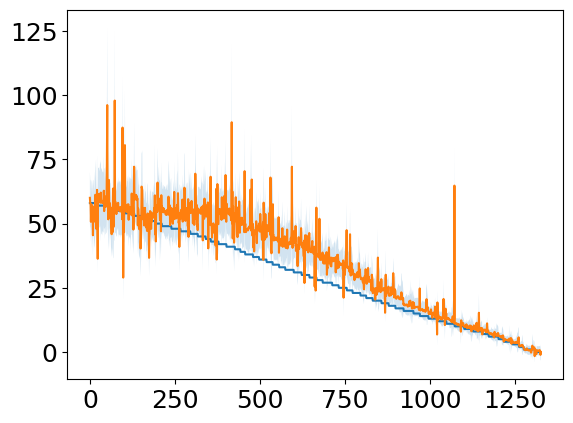

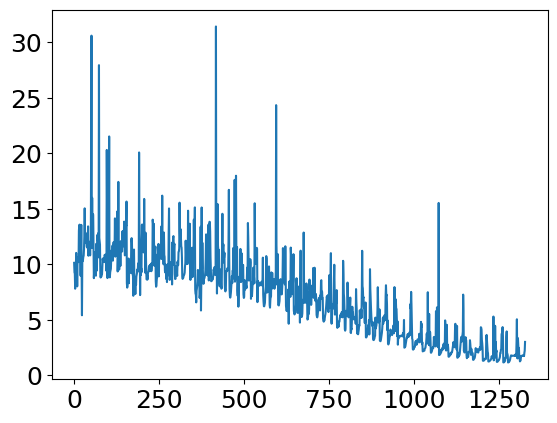

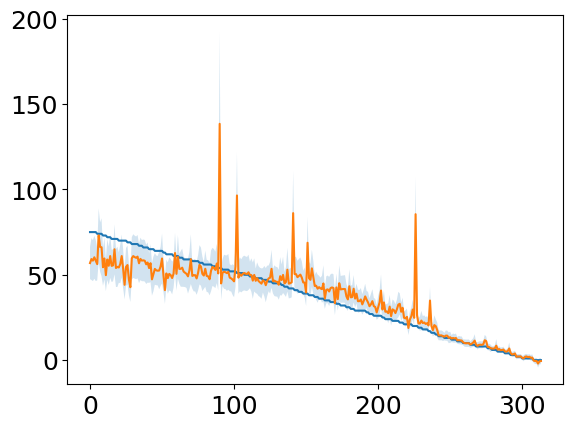

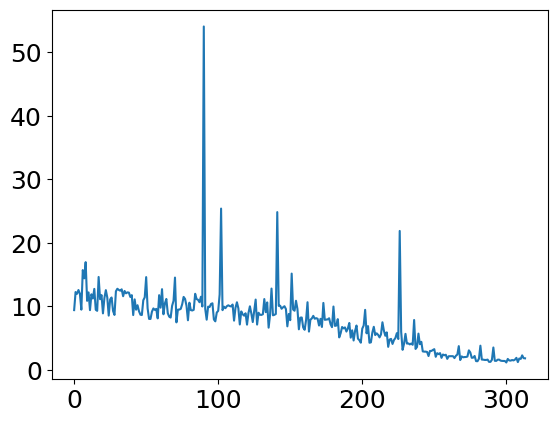

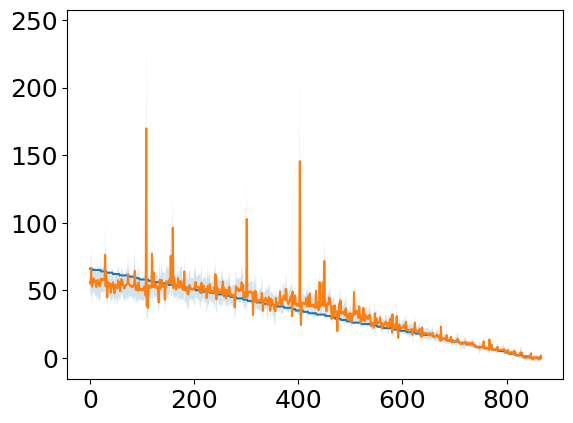

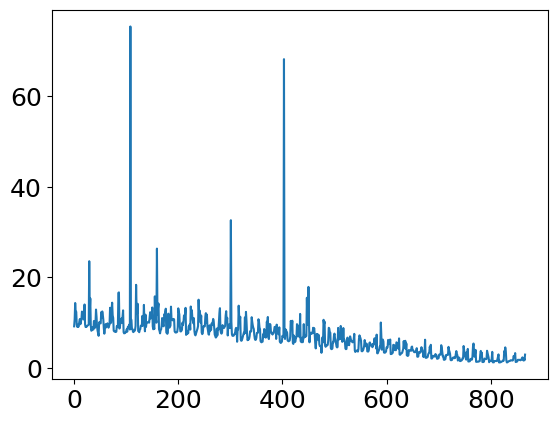

In [13]:
y_true = allresults_df[allresults_df['dataset']=='test11']['True'].values
y_pred = allresults_df[allresults_df['dataset']=='test11']['DE_mu_eff'].values
sigma_pred = allresults_df[allresults_df['dataset']=='test11']['DE_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_df[allresults_df['dataset']=='test14']['True'].values
y_pred = allresults_df[allresults_df['dataset']=='test14']['DE_mu_eff'].values
sigma_pred = allresults_df[allresults_df['dataset']=='test14']['DE_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_df[allresults_df['dataset']=='test15']['True'].values
y_pred = allresults_df[allresults_df['dataset']=='test15']['DE_mu_eff'].values
sigma_pred = allresults_df[allresults_df['dataset']=='test15']['DE_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

In [14]:
# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    """
    Input: 
    y_true - true values
    mu     - predicted mean
    sigma  - predicted standard deviation
    
    Output:
    exp_CIs - expected confidence
    pred_CIs - predicted confidence
    """
    exp_CIs = np.linspace(1e-10, 1-1e-10, 1000)
    pred_CIs=[]
    for exp_CI in sorted(exp_CIs):
        intervals = scipy.stats.norm.interval(exp_CI, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        pred_CIs.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    ECE = np.mean(np.abs(exp_CIs - pred_CIs))
    return 100*exp_CIs, 100*np.array(pred_CIs), ECE*100  # converting to percentages

4.475402232503635


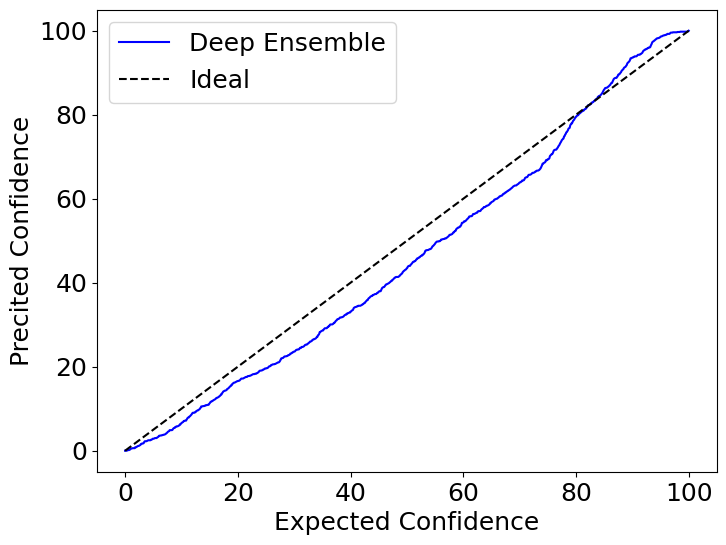

In [15]:
allresults_df_sorted = allresults_df.loc[allresults_df['dataset']=='test11']
allresults_df_sorted = allresults_df_sorted.sort_values(by='True', ascending=True)

alphas, CI_DE,ECE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                       allresults_df_sorted['DE_mu_eff'].values, 
                                       allresults_df_sorted['DE_sigma_eff'].values)

print(ECE)


fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()


In [24]:
## Multiple runs
niter = 2
allCI_DE = np.zeros((1000, niter,len(dataset)))
pbar=ProgressBar()


allresults_df = pd.DataFrame()
for myiter in pbar(range(niter)):
    prediction_fns=[]
    train_mae=[]
    for i in range(2):
        my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'sigmoid')
        train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
        prediction_fns.append(my_func)

    nmodels_select = 2
    final_DE_fns = []
    for i in range(nmodels_select):
        final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        for i in range(nmodels_select):
            result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
            result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

        result_df = get_ensemble(result_df, "DE", nmodels_select)
        print(myiter)
        result_df['iteration'] = myiter
        allresults_df = pd.concat([allresults_df, result_df], axis = 0)
    

    for ii,myset in enumerate(dataset):
        allresults_df_sorted = allresults_df.loc[allresults_df['dataset']==myset]
        allresults_df_sorted = allresults_df_sorted.sort_values(by='True', ascending=True)

        alphas, CI_DE,exe = get_confidence_interval(allresults_df_sorted['True'].values, 
                                               allresults_df_sorted['DE_mu_eff'].values, 
                                               allresults_df_sorted['DE_sigma_eff'].values)
        allCI_DE[:,myiter,ii] = CI_DE
allresults_df.to_excel("results/DeepEnsemble_CMAPPS_results.xlsx")

Train on 10527 samples
Epoch 1/100
10527/10527 [==============================] - 1s 98us/sample - loss: -0.6774
Epoch 2/100
10527/10527 [==============================] - 1s 52us/sample - loss: -0.8825
Epoch 3/100
10527/10527 [==============================] - 1s 52us/sample - loss: -0.9233
Epoch 4/100
10527/10527 [==============================] - 1s 53us/sample - loss: -0.9794
Epoch 5/100
10527/10527 [==============================] - 1s 51us/sample - loss: -1.1013
Epoch 6/100
10527/10527 [==============================] - 1s 52us/sample - loss: -1.2753
Epoch 7/100
10527/10527 [==============================] - 1s 55us/sample - loss: -1.3666
Epoch 8/100
10527/10527 [==============================] - 1s 54us/sample - loss: -1.4062
Epoch 9/100
10527/10527 [==============================] - 1s 54us/sample - loss: -1.4295
Epoch 10/100
10527/10527 [==============================] - 1s 55us/sample - loss: -1.4557
Epoch 11/100
10527/10527 [==============================] - 1s 53us/sample -

10527/10527 [==============================] - 1s 56us/sample - loss: -2.0750
Epoch 81/100
10527/10527 [==============================] - 1s 53us/sample - loss: -2.0719
Epoch 82/100
10527/10527 [==============================] - 1s 51us/sample - loss: -2.0679
Epoch 83/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.0605
Epoch 84/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.0782
Epoch 85/100
10527/10527 [==============================] - 1s 52us/sample - loss: -2.0823
Epoch 86/100
10527/10527 [==============================] - 1s 55us/sample - loss: -2.0739
Epoch 87/100
10527/10527 [==============================] - 1s 52us/sample - loss: -2.0779
Epoch 88/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.0873
Epoch 89/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.0937
Epoch 90/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.0869
Epoch 91/100

Train on 10527 samples
Epoch 1/100
10527/10527 [==============================] - 1s 98us/sample - loss: -0.2707
Epoch 2/100
10527/10527 [==============================] - 1s 52us/sample - loss: -0.7968
Epoch 3/100
10527/10527 [==============================] - 1s 55us/sample - loss: -0.9247
Epoch 4/100
10527/10527 [==============================] - 1s 52us/sample - loss: -1.0360
Epoch 5/100
10527/10527 [==============================] - 1s 54us/sample - loss: -1.2177
Epoch 6/100
10527/10527 [==============================] - 1s 54us/sample - loss: -1.3419
Epoch 7/100
10527/10527 [==============================] - 1s 54us/sample - loss: -1.3940
Epoch 8/100
10527/10527 [==============================] - 1s 55us/sample - loss: -1.4268
Epoch 9/100
10527/10527 [==============================] - 1s 52us/sample - loss: -1.4473
Epoch 10/100
10527/10527 [==============================] - 1s 54us/sample - loss: -1.4704
Epoch 11/100
10527/10527 [==============================] - 1s 55us/sample -

Epoch 80/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.1561
Epoch 81/100
10527/10527 [==============================] - 1s 55us/sample - loss: -2.1472
Epoch 82/100
10527/10527 [==============================] - 1s 56us/sample - loss: -2.1570
Epoch 83/100
10527/10527 [==============================] - 1s 53us/sample - loss: -2.1629
Epoch 84/100
10527/10527 [==============================] - 1s 55us/sample - loss: -2.1592
Epoch 85/100
10527/10527 [==============================] - 1s 56us/sample - loss: -2.1692
Epoch 86/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.1624
Epoch 87/100
10527/10527 [==============================] - 1s 56us/sample - loss: -2.1769
Epoch 88/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.1702
Epoch 89/100
10527/10527 [==============================] - 1s 54us/sample - loss: -2.1745
Epoch 90/100
10527/10527 [==============================] - 1s 56us/sample - loss: -2.1697

100% |#########################################################################################################################################################################################|


In [25]:
np.unique(allresults_df['iteration'].values)

array([0, 1])

In [ ]:
for d in dataset:
    idx = np.where([d == dataset[i] for i in range(len(dataset))])[0][0]

    fig = plt.figure(figsize=(8,6))
    plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    plt.fill_between(alphas,
                    np.mean(allCI_DE[:,:,idx], axis = 1)+np.std(allCI_DE[:,:,idx], axis = 1),
                    np.mean(allCI_DE[:,:,idx], axis = 1)-np.std(allCI_DE[:,:,idx], axis = 1),
                    color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    plt.xlabel('Expected Confidence')
    plt.ylabel('Precited Confidence')
    plt.legend()
    plt.savefig('figures/deep_ensemble_cmapps_{}.pdf'.format(d))

## UQ Model: MC Dropout

Simple MLP architecture with 10% dropout probability

In [ ]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):

    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = .10)(x)
    x = Dense(10, activation = actfn)(x)
    x = Dropout(rate = .10)(x)
    mu = Dense(1, activation = actfn)(x)

    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 1)

    return model

In [ ]:
nmodels = 1
all_models_MC=[]
all_mae_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 500, 'sigmoid')
    all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)

In [ ]:
select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]
print("Train MAE: ", mae(K.get_value(select_modelMC(Xtrain_norm))*(np.max(Ytrain)), Ytrain))
print("Test11 MAE: ", mae(K.get_value(select_modelMC(Xtest11_norm))*(np.max(Ytrain)), Ytest11))
print("Test14 MAE: ", mae(K.get_value(select_modelMC(Xtest14_norm))*(np.max(Ytrain)), Ytest14))
print("Test15 MAE: ", mae(K.get_value(select_modelMC(Xtest15_norm))*(np.max(Ytrain)), Ytest15))
print("Test MAE: ", mae(K.get_value(select_modelMC(Xtest_norm))*(np.max(Ytrain)), Ytest))


In [ ]:
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    if UQmodelcode=="DE":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             + np.mean(df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

In [ ]:
nmodels_select=20
dataset = ['train', 'test', 'test11', 'test14', 'test15']
allresults_MCdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in tqdm(range(nmodels_select)):
        result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

    allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodels_select)

In [ ]:
y_true = allresults_MCdf[allresults_MCdf['dataset']=='test11']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='test11']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='test11']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_MCdf[allresults_MCdf['dataset']=='test14']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='test14']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='test14']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)



y_true = allresults_MCdf[allresults_MCdf['dataset']=='test15']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='test15']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='test15']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

In [ ]:
y_true = allresults_MCdf[allresults_MCdf['dataset']=='train']['True'].values
y_pred = allresults_MCdf[allresults_MCdf['dataset']=='train']['MC_mu_eff'].values
sigma_pred = allresults_MCdf[allresults_MCdf['dataset']=='train']['MC_sigma_eff'].values
plt.figure()
plt.plot(y_true)
plt.plot(y_pred)
plt.fill_between(np.arange(len(y_pred)), y_pred-sigma_pred,y_pred+sigma_pred, alpha = 0.2)
plt.figure()
plt.plot(sigma_pred)

## Results - Visualization

In [ ]:
dataset_='train'
allresults_MCdf_ = allresults_MCdf[allresults_MCdf['dataset']==dataset_].sort_values(by='True', ascending=True)

alphas, CI_DE,_ = get_confidence_interval(allresults_MCdf_['True'].values, 
                                       allresults_MCdf_['MC_mu_eff'].values, 
                                       allresults_MCdf_['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

In [ ]:
## Repeat 10 times
nmodels = 1 # total models trained and best one picked
nmodels_select = 20 # run 5 times per each select model with dropout
niter = 10

allCI_MC = np.zeros((1000, niter,len(dataset)))
pbar=ProgressBar()

allresults_MCdf = pd.DataFrame()
for myiter in pbar(range(niter)):
    all_models_MC=[]
    all_mae_train_MC = np.zeros(nmodels,)
    pbar = ProgressBar()
    for i in range(nmodels):
        model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 200, 'sigmoid')
        all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
        all_models_MC.append(model_MC)

    select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]

    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        for i in range(nmodels_select):
            result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))
        result_df['iteration'] = myiter
        allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)

    allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodels_select)
    
    for ii,myset in enumerate(dataset):
        allresults_df_sorted = allresults_MCdf.loc[allresults_MCdf['dataset']==myset]
        allresults_df_sorted = allresults_df_sorted.sort_values(by='True', ascending=True)

        alphas, CI_MC,_ = get_confidence_interval(allresults_df_sorted['True'].values, 
                                               allresults_df_sorted['MC_mu_eff'].values, 
                                               allresults_df_sorted['MC_sigma_eff'].values)
        allCI_MC[:,myiter,ii] = CI_MC
allresults_MCdf.to_excel("results/MCDropout_CMAPPS_results.xlsx") 

In [ ]:
for d in dataset:
    idx = np.where([d == dataset[i] for i in range(len(dataset))])[0][0]

    fig = plt.figure(figsize=(8,6))
    plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    plt.fill_between(alphas,
                    np.mean(allCI_MC[:,:,idx], axis = 1)+np.std(allCI_MC[:,:,idx], axis = 1),
                    np.mean(allCI_MC[:,:,idx], axis = 1)-np.std(allCI_MC[:,:,idx], axis = 1),
                    color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')
    plt.fill_between(alphas,
                    np.mean(allCI_DE[:,:,idx], axis = 1)+np.std(allCI_DE[:,:,idx], axis = 1),
                    np.mean(allCI_DE[:,:,idx], axis = 1)-np.std(allCI_DE[:,:,idx], axis = 1),
                    color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')

    plt.xlabel('Expected Confidence')
    plt.ylabel('Observed Confidence')
    plt.legend()
    plt.savefig('figures/MCDropout_cmapps_{}.pdf'.format(d))